This section of code refers to data drift detection within the dataset. It starts by searching for three different cameras. Ideally, we want three cameras with large amounts of data.

## Data cleaning and manipulation

In [1]:
# cleaning data
import os
import pandas as pd

# viewing images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



In [6]:
# This function returns the file path, site and label of each image
# returns a 
def label_images(base_dir):
    image_data = []

    # Traverse the base directory to find all site directories
    for site in os.listdir(base_dir):
        site_path = os.path.join(base_dir, site)
        if os.path.isdir(site_path):
            # Define the subdirectories within each site
            subdirs = ['blocked', 'clear', 'other']

            # Traverse each subdirectory
            for subdir in subdirs:
                subdir_path = os.path.join(site_path, subdir)

                if os.path.exists(subdir_path):
                    # Walk through the subdirectory
                    for root, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                                # Full file path
                                file_path = os.path.join(root, file)

                                # Append the data to the list
                                image_data.append({
                                    'file_path': file_path,
                                    'site': site,
                                    'label': subdir
                                })

    # Create a DataFrame from the collected data
    df = pd.DataFrame(image_data)

    return df

# Executed
base_dir = 'Data/blockagedetection_dataset/images'
df_images = label_images(base_dir)

print(df_images.head(5))

                                           file_path                   site  \
0  Data/blockagedetection_dataset/images/Devon_Ho...  Devon_Holbeam_Impound   
1  Data/blockagedetection_dataset/images/Devon_Ho...  Devon_Holbeam_Impound   
2  Data/blockagedetection_dataset/images/Devon_Ho...  Devon_Holbeam_Impound   
3  Data/blockagedetection_dataset/images/Devon_Ho...  Devon_Holbeam_Impound   
4  Data/blockagedetection_dataset/images/Devon_Ho...  Devon_Holbeam_Impound   

     label  
0  blocked  
1  blocked  
2  blocked  
3  blocked  
4  blocked  


In [3]:
# Filter out the 'other' label
df_filtered = df_images[df_images['label'].isin(['blocked', 'clear'])]

# Group by site and label, then count the images
summary = df_filtered.groupby(['site', 'label']).size().unstack(fill_value=0)

# Determine the minimum count between blocked and clear labels for each site
summary['balanced'] = summary[['blocked', 'clear']].min(axis=1)


In [4]:
# Collect balanced data for each site
balanced_data = []
for site in summary.index:
    min_count = summary.loc[site, 'balanced']
    
    blocked_images = df_filtered[(df_filtered['site'] == site) & (df_filtered['label'] == 'blocked')].sample(min_count)
    clear_images = df_filtered[(df_filtered['site'] == site) & (df_filtered['label'] == 'clear')].sample(min_count)
    
    balanced_data.append(blocked_images)
    balanced_data.append(clear_images)

# Concatenate the balanced data
balanced_df = pd.concat(balanced_data)

# Aggregate the counts for balanced images
balanced_summary = balanced_df.groupby(['site', 'label']).size().unstack(fill_value=0)
balanced_summary['total'] = balanced_summary['blocked'] + balanced_summary['clear']

# Select the top three sites with the highest number of balanced images
top_balanced_sites = balanced_summary.nlargest(6, 'total')

print(top_balanced_sites)

label                           blocked  clear  total
site                                                 
sites_corshamaqueduct_cam1          733    733   1466
Cornwall_BudeCedarGrove             673    673   1346
Cornwall_Crinnis                    639    639   1278
Devon_BarnstapleConeyGut_Scree      596    596   1192
Cornwall_Mevagissey_PreScree        541    541   1082
sites_sheptonmallet_cam2            538    538   1076


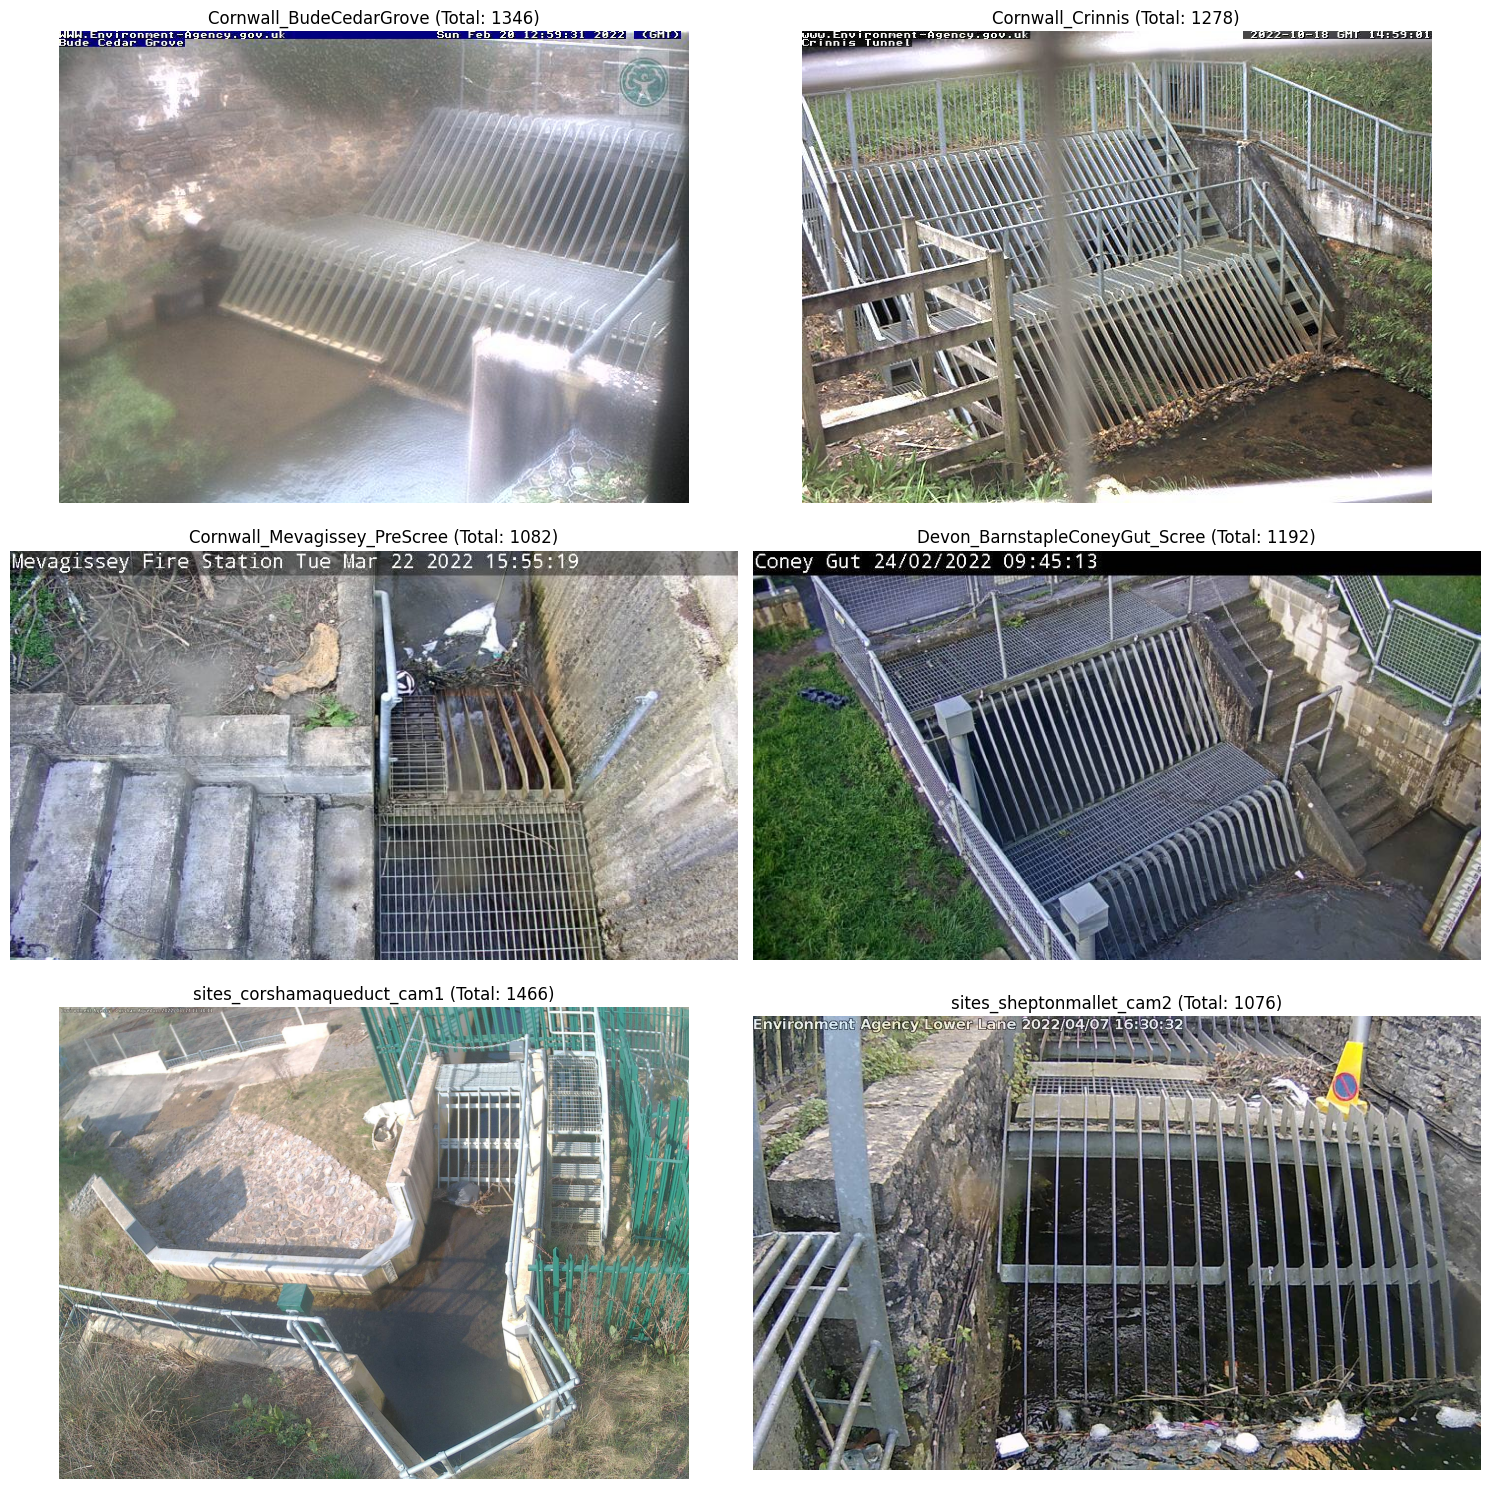

In [5]:
# Select one image per site 
example_images = balanced_df[balanced_df['site'].isin(top_balanced_sites.index)].groupby('site').first().reset_index()

#  get the total count
example_images = example_images.merge(top_balanced_sites['total'], on='site')

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < len(example_images):
        img_path = example_images.iloc[i]['file_path']
        img = mpimg.imread(img_path)
        site = example_images.iloc[i]['site']
        total = example_images.iloc[i]['total']
        ax.imshow(img)
        ax.set_title(f"{site} (Total: {total})")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

After viewing these images and noting the different trash screens, I decide to use the sites: sites_corshamaqueduct_cam1, Cornwall_BudeCedarGrove, Devon_BarnstapleConeyGut_Scree. Although Cornwall_Crinnis has 84 more images than Devon_BarnstapleConeyGut_Scree, i have chosen to use exclude this site at is similar to sites_corshamaqueduct_cam1.

## Seasonal data divide.

Now that we have the three sites, I divide each site up into seasons. And merge the data so to have summer, winter, autumn and spring data. 

According to this website, the season dates are defined as follows:

Thus for us in Europe:

Spring is deemed to start at the Vernal Equinox (near 20 March)
Summer at the Summer Solstice (near 21 June)
Autumn at the Autumn Equinox (near 23 September)
Winter at the Winter Solstice (near 22 December).

https://www.rmg.co.uk/stories/topics/when-does-spring-start#:~:text=Spring%20is%20deemed%20to%20start,Solstice%20(near%2022%20December).

In now need to divide the data up by dates

Spring March 20 - June 20
Summer June 21 - September 22
Autumn September 23 - December 21
Winter December 22 - March 19

In [ ]:
more changes